In [1]:
import os
import pandas as pd
import librosa
import librosa.display
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
path = 'sensor_logger'
start_time = 15
end_time = 55
dict_types = {'time':'float', 'dt':'float', 'x':'float', 'y':'float', 'z':'float'}
x_list = []
y_list = []
z_list = []
folder_list = []
activity_list = []
wav_list = []
stft_list = []
stft_mean_list = []
stft_std_list = []
zcr_list = []
N_FFT = 4096
HOP_SIZE = 1024
for root, dirs, files in os.walk(path, topdown=False):
    for name in files:
        if name == 'Accelerometer.csv':
            acc_path = os.path.join(root, name) 
            data = pd.read_csv(acc_path, names=['time', 'dt', 'z', 'y', 'x'], skiprows=[0], header=None, dtype = dict_types)
            x_data = data[(data['dt'] >=start_time) & (data['dt'] <=end_time)].x
            y_data = data[(data['dt'] >=start_time) & (data['dt'] <=end_time)].y
            z_data = data[(data['dt'] >=start_time) & (data['dt'] <=end_time)].z
            x_list.append(x_data-np.mean(x_data)/np.std(x_data))
            y_list.append(y_data-np.mean(y_data)/np.std(y_data))
            z_list.append(z_data-np.mean(z_data)/np.std(z_data))
        if name == 'Microphone.caf':
            mic_path = os.path.join(root, name)    
            wav_data, sr = librosa.load(mic_path, sr=None, mono=True)
            stft = librosa.amplitude_to_db(np.abs(librosa.stft(wav_data[start_time*sr:end_time*sr], n_fft=N_FFT, hop_length=HOP_SIZE, win_length=N_FFT,
                                                                    window='hann', center=True, pad_mode='constant' )), ref=np.max)
                                                                    # N_FFT/2 number of frequency bins x number of frames t
            zcr = librosa.feature.zero_crossing_rate(wav_data[start_time*sr:end_time*sr], frame_length=112896, hop_length=28224)
            folder = mic_path.split('/')[1]
            folder_list.append(folder)
            activity_list.append(folder.split('-')[0])
            wav_list.append(wav_data[sr*start_time:sr*end_time])
            stft_list.append(stft)
            stft_mean_list.append(np.mean(stft, axis=0)) # axis=0 -> average across time bins, axis=1 -> average across frequency bins
            stft_std_list.append(np.std(stft, axis=0))
            zcr_list.append(zcr[0])


In [22]:
df = pd.DataFrame()
df['x'] = x_list
df['y'] = y_list
df['z'] = z_list
df['wav_list'] = wav_list
df['stft'] = stft_list
df['folder'] = folder_list
df['activity'] = activity_list
df['stft_mean'] = stft_mean_list
df['stft_std'] = stft_std_list
df['zcr'] = zcr_list
x_tot = []
y_tot = []
z_tot = []
x_mean = []
y_mean = []
z_mean = []
x_std = []
y_std = []
z_std = []
x_fft = []
y_fft = []
z_fft = []
corr_xy_frames = []
corr_yz_frames = []
corr_xz_frames = []
mag = []
frame_size = 256
hop_size = 128
for i in range(0, len(df)):
    x_frames = []
    y_frames = []
    z_frames = []
    # correlation
    corr_xy_list = []
    corr_yz_list = []
    corr_xz_list = []
    for j in range(0, df['x'][i].shape[0] - frame_size, hop_size):
        x = df['x'][i].values[j: j + frame_size]
        y = df['y'][i].values[j: j + frame_size]
        z = df['z'][i].values[j: j + frame_size]
    
        x_frames.append(x)
        y_frames.append(y)
        z_frames.append(z)
    x_tot.append(x_frames) # 30x256, 30 windows of length 256 each
    y_tot.append(y_frames) # 30x256, 30 windows of length 256 each
    z_tot.append(z_frames) # 30x256, 30 windows of length 256 each

    x_mean.append(np.mean(x_frames,axis=1)) # mean value of each window
    y_mean.append(np.mean(y_frames,axis=1)) # mean value of each window
    z_mean.append(np.mean(z_frames,axis=1)) # mean value of each window

    x_std.append(np.std(x_frames,axis=1)) # std of each window
    y_std.append(np.std(y_frames,axis=1)) 
    z_std.append(np.std(z_frames,axis=1)) 

    mag.append(np.sqrt(np.array(x_frames)**2+np.array(y_frames)**2+np.array(z_frames)**2).flatten())

    # FFT energy?
    x_fft.append(np.abs(np.fft.fft(x_frames))[0:int(frame_size/2)+1])
    y_fft.append(np.abs(np.fft.fft(y_frames))[0:int(frame_size/2)+1])
    z_fft.append(np.abs(np.fft.fft(z_frames))[0:int(frame_size/2)+1])


    for i in range(0, len(x_frames)):
        corr_xy, _ = pearsonr(x_frames[i], y_frames[i])
        corr_yz, _ = pearsonr(y_frames[i], z_frames[i])
        corr_xz, _ = pearsonr(x_frames[i], z_frames[i])

        corr_xy_list.append(corr_xy)
        corr_yz_list.append(corr_yz)
        corr_xz_list.append(corr_xz)
    corr_xy_frames.append(corr_xy_list)
    corr_yz_frames.append(corr_xy_list)
    corr_xz_frames.append(corr_xy_list)

df['x_frames'] = x_tot
df['y_frames'] = y_tot
df['z_frames'] = z_tot
df['x_mean'] = x_mean
df['y_mean'] = y_mean
df['z_mean'] = z_mean
df['x_std'] = x_std
df['y_std'] = y_std
df['z_std'] = z_std
df['x_std'] = x_std
df['y_std'] = y_std
df['z_std'] = z_std
df['x_fft'] = x_fft
df['y_fft'] = y_fft
df['z_fft'] = z_fft
df['corr_xy'] = corr_xy_frames
df['corr_yz'] = corr_yz_frames
df['corr_xz'] = corr_xz_frames
df['mag'] = mag
# group holding activities
df['activity'] = df.activity.str.replace(r'landscape_hold', 'hold')
df['activity'] = df.activity.str.replace(r'portrait_hold', 'hold')

# group tapping activities
#df['activity'] = df.activity.str.replace(r'tap_portrait', 'tap')

# group swiping activities
#df['activity'] = df.activity.str.replace(r'swipe_lr', 'swipe')
#df['activity'] = df.activity.str.replace(r'swipe_rl', 'swipe')

    
# drop holding activities
df = df[~df['activity'].str.contains('hold')]
df = df[~df['activity'].str.contains('call')]

# drop tapping
df = df[~df['activity'].str.contains('tap')]

# drop on_table_face activities
df = df[~df['activity'].str.contains('on_table_face')]


# group tapping, swiping, and scrolling activities
df.loc[df['activity'].str.contains('tap'), 'activity'] = 'tap'
df.loc[df['activity'].str.contains('tapping'), 'activity'] = 'tap'
df.loc[df['activity'].str.contains('swipe'), 'activity'] = 'swipe'
df.loc[df['activity'].str.contains('swiping'), 'activity'] = 'swipe'
df.loc[df['activity'].str.contains('scroll'), 'activity'] = 'scroll'
df.loc[df['activity'].str.contains('scrolling'), 'activity'] = 'scroll'


df['activity'] = df.activity.str.replace(r'_free$', '')
df['activity'] = df.activity.str.replace(r'_lap$', '')
df['activity'] = df.activity.str.replace(r'_table$', '')
df['activity'] = df.activity.str.replace(r'_standing$', '')


In [24]:
def extract_features(df):
    y = df['activity']
    # 'x_mean', 'y_mean', 'z_mean',
    features_list = ['x_mean', 'y_mean', 'z_mean', 'x_std', 'y_std', 'z_std', 'corr_xy', 'mag']
    
    stft = np.asarray(df['stft'])
    stft_mean = np.asarray(df['stft_mean'])
    stft_std = np.asarray(df['stft_std'])

    xfft = np.asarray(df['x_fft'])
    yfft = np.asarray(df['y_fft'])
    zfft = np.asarray(df['z_fft'])

    for i in range(0, stft.shape[0]):
        stft[i] = stft[i].flatten()
        xfft[i] = xfft[i].flatten()
        yfft[i] = yfft[i].flatten()
        zfft[i] = zfft[i].flatten()

    stft_arr = np.vstack(stft)
    stft_mean_arr = np.vstack(stft_mean)
    stft_std_arr = np.vstack(stft_std)

    xfft_arr = np.vstack(xfft)
    yfft_arr = np.vstack(yfft)
    zfft_arr = np.vstack(zfft)
    
    # xfft_arr, yfft_arr, zfft_arr
    # stft_mean_arr, stft_std_arr, 
    X = np.hstack((stft_mean_arr, stft_std_arr, xfft_arr, yfft_arr, zfft_arr ))
    for f in features_list:
        feature = np.vstack(np.asarray(df[f]))
        X = np.hstack((X, feature))
        
    return (X,y)

Random forest classifier: 
mean precision: 0.5833333333333333 mean recall: 0.5833333333333333 mean F1 score: 0.5833333333333333 


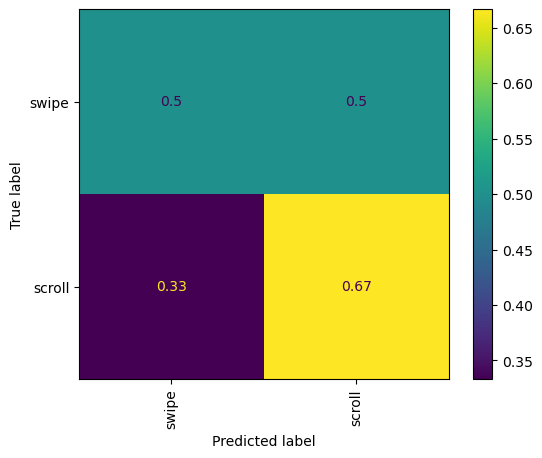

In [38]:
folders_list = df['folder'].unique()
# randomly select 1/5 folders for testing
test_n = 5
test_indices = np.random.choice(len(folders_list), test_n, replace=False)

test_folders=[]
for i in test_indices:
    test_folders.append(folders_list[i])
test_df = df[df['folder'].isin(test_folders)]
X_test, y_test = extract_features(test_df)

train_df = df[~df['folder'].isin(test_folders)]
X_train, y_train = extract_features(train_df)

rf = RandomForestClassifier(n_estimators=20, random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1_scores = f1_score(y_test, y_pred, average='macro')

print("Random forest classifier: ")
print("mean precision: {precision} mean recall: {recall} mean F1 score: {f1} ".format(recall=np.mean(recall), precision=np.mean(precision), f1=np.mean(f1_scores)))

# plot confusion matrix
labels = set(y_test).union(set(y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.yticks(rotation='horizontal')
plt.xticks(rotation='vertical')
plt.show()

/Users/az8797/miniforge3/envs/tensorflow-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/az8797/miniforge3/envs/tensorflow-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


mean precision: 0.0 mean recall: 0.0 mean F1 score: 0.0 


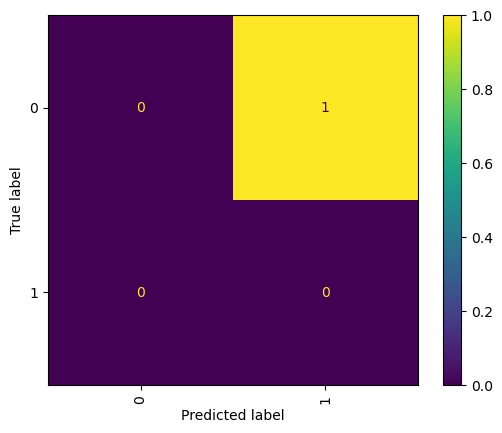

In [37]:
from sklearn.naive_bayes import GaussianNB

label = LabelEncoder()
y_train_label = label.fit_transform(y_train)
y_test_label = label.fit_transform(y_test)

gnb =  GaussianNB()
gnb.fit(X_train, y_train_label)
y_pred = gnb.predict(X_test)
precision = precision_score(y_test_label, y_pred, average='macro')
recall = recall_score(y_test_label, y_pred, average='macro')
f1_scores = f1_score(y_test_label, y_pred, average='macro')

print("mean precision: {precision} mean recall: {recall} mean F1 score: {f1} ".format(recall=np.mean(recall), precision=np.mean(precision), f1=np.mean(f1_scores)))

# plot confusion matrix
labels = set(y_test_label).union(set(y_pred))

cm = confusion_matrix(y_test_label, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.yticks(rotation='horizontal')
plt.xticks(rotation='vertical')
plt.show()


In [990]:
y_test_label, y_pred
# y_pred, y_test
# wrong with audio: 5, 14, 31, 36, 42, 44, 48, 49
# wrong IMU only: 5, 6, 14, 19, 31, 32, 33, 34, 44, 48

(array([1, 0, 0, 1, 0]), array([1, 1, 1, 0, 1]))

[Text(0.5, 1.0, 'scroll_table-2023-03-01_00-57-36')]

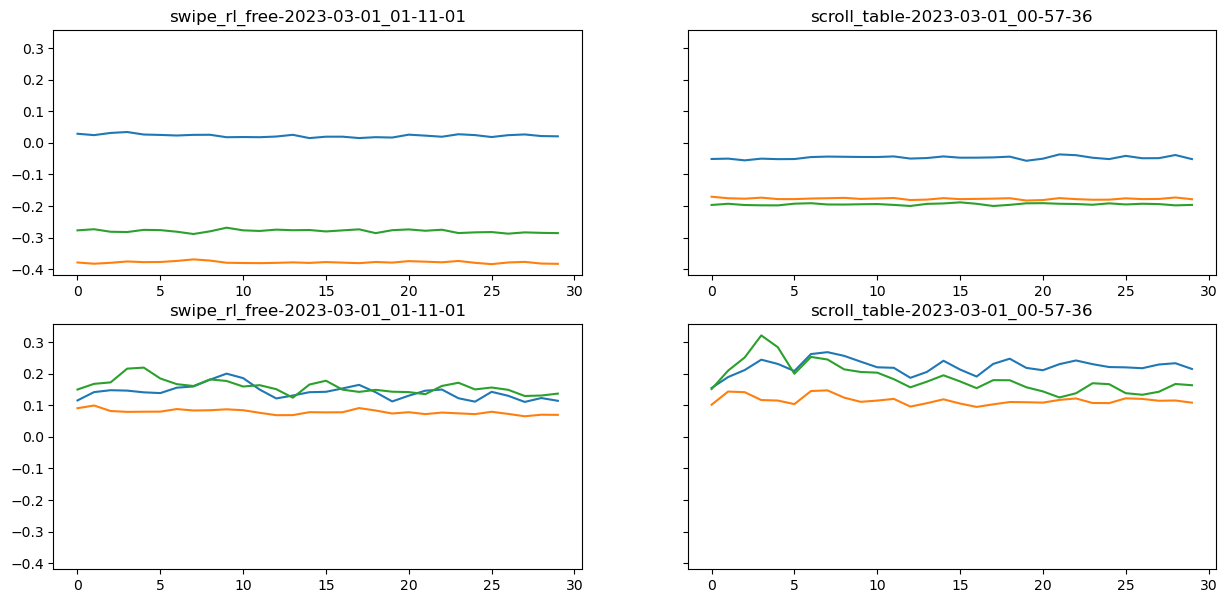

In [908]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 7), sharey=True)
swipe_ind = 0
scroll_ind = 1
ax[0,0].plot(df['x_mean'].iloc[swipe_ind])
ax[0,0].plot(df['y_mean'].iloc[swipe_ind])
ax[0,0].plot(df['z_mean'].iloc[swipe_ind])
ax[0,0].set(title=df['folder'].iloc[swipe_ind])

ax[0,1].plot(df['x_mean'].iloc[scroll_ind])
ax[0,1].plot(df['y_mean'].iloc[scroll_ind])
ax[0,1].plot(df['z_mean'].iloc[scroll_ind])
ax[0,1].set(title=df['folder'].iloc[scroll_ind])

# ?
ax[1,0].plot(df['x_std'].iloc[swipe_ind])
ax[1,0].plot(df['y_std'].iloc[swipe_ind])
ax[1,0].plot(df['z_std'].iloc[swipe_ind])
ax[1,0].set(title=df['folder'].iloc[swipe_ind])

ax[1,1].plot(df['x_std'].iloc[scroll_ind])
ax[1,1].plot(df['y_std'].iloc[scroll_ind])
ax[1,1].plot(df['z_std'].iloc[scroll_ind])
ax[1,1].set(title=df['folder'].iloc[scroll_ind])


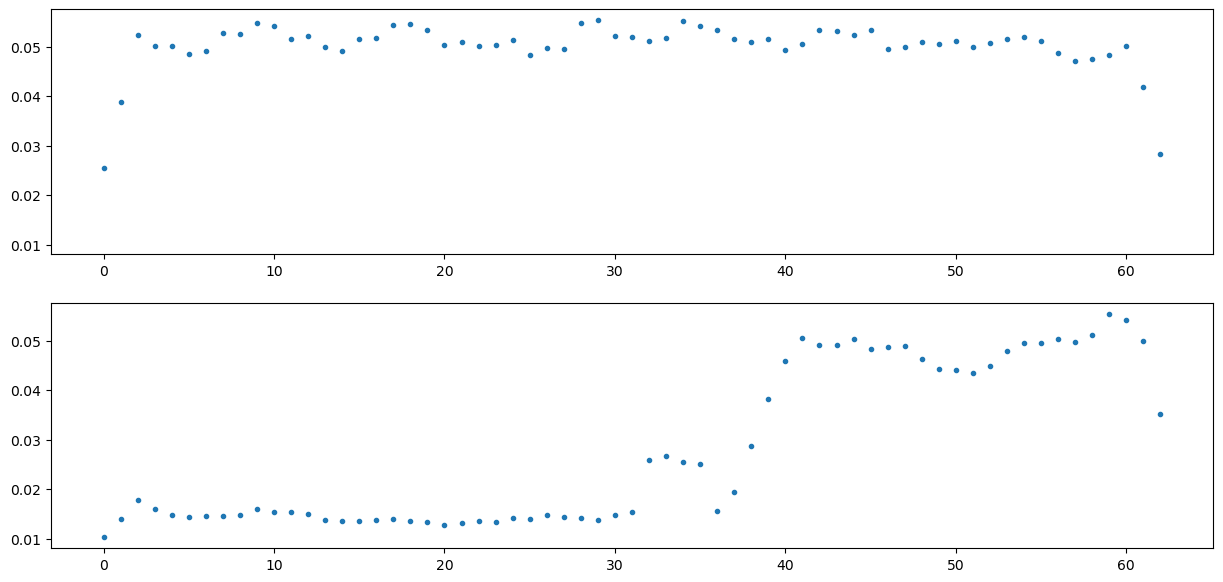

In [1176]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 7), sharey=True)
swipe_ind = 0
scroll_ind = 1
ax[0].plot(df['zcr'].iloc[swipe_ind], '.')
ax[1].plot(df['zcr'].iloc[scroll_ind], '.')
#plt.plot(df['zcr'].iloc[swipe_ind], 'x')
plt.show()


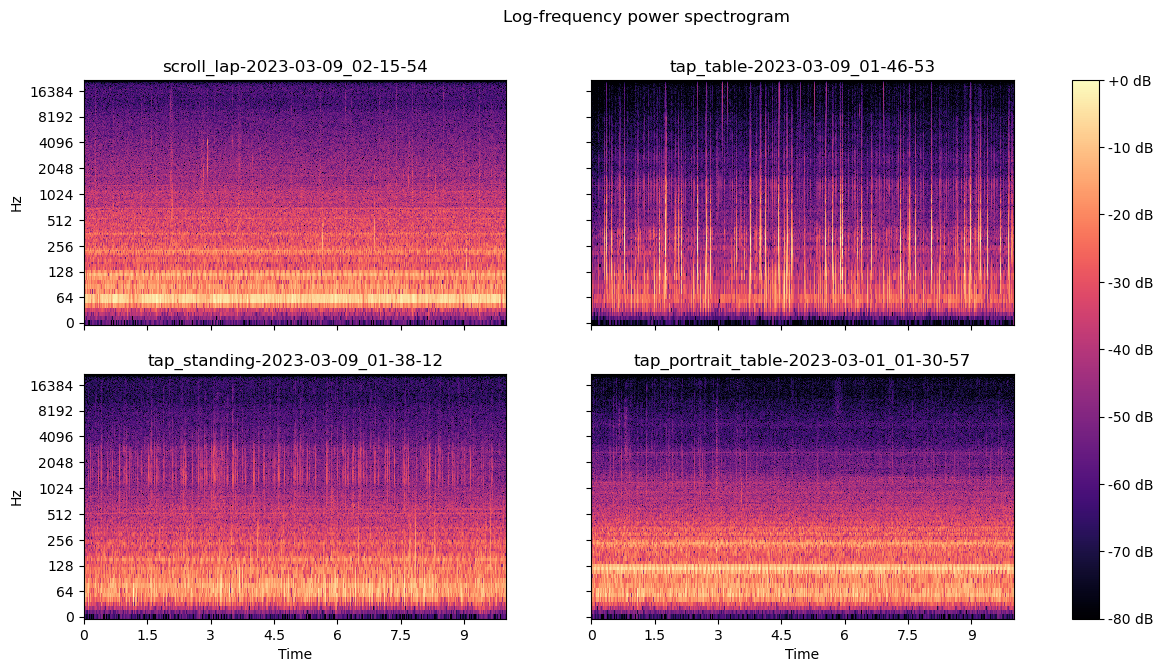

In [610]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 7), sharey=True)

img = librosa.display.specshow(df['stft'].iloc[4], y_axis='log', x_axis='time',sr=sr, ax=ax[0,0])
ax[0,0].set(title=df['folder'].iloc[4])
ax[0,0].label_outer()
img = librosa.display.specshow(df['stft'].iloc[10], y_axis='log', x_axis='time',sr=sr, ax=ax[0,1])
ax[0,1].set(title=df['folder'].iloc[10])
ax[0,1].label_outer()
img = librosa.display.specshow(df['stft'].iloc[13], y_axis='log', x_axis='time',sr=sr, ax=ax[1,0])
ax[1,0].set(title=df['folder'].iloc[13])
ax[1,0].label_outer()
img = librosa.display.specshow(df['stft'].iloc[14], y_axis='log', x_axis='time',sr=sr, ax=ax[1,1])
ax[1,1].set(title=df['folder'].iloc[14])
ax[1,1].label_outer()
plt.suptitle("Log-frequency power spectrogram")
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [567]:
df.index

Int64Index([0, 5, 6, 14, 15, 25, 31, 32, 33, 36, 39, 42, 44, 48, 49], dtype='int64')